In [1]:
%load_ext rpy2.ipython
%matplotlib inline
from fbprophet import Prophet
import pandas as pd
from matplotlib import pyplot as plt
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('../examples/example_wp_log_peyton_manning.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=366)

Importing plotly failed. Interactive plots will not work.


In [2]:
%%R
library(prophet)
df <- read.csv('../examples/example_wp_log_peyton_manning.csv')
m <- prophet(df)
future <- make_future_dataframe(m, periods=366)

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values. This figure illustrates a simulated historical forecast on the Peyton Manning dataset, where the model was fit to a initial history of 5 years, and a forecast was made on a one year horizon.

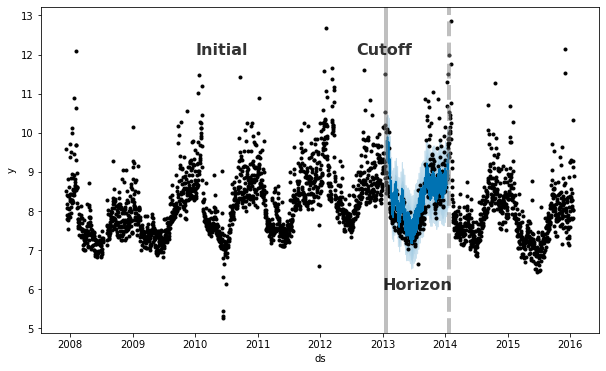

In [2]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(
    m, '365 days', initial='1825 days', period='365 days')
cutoff = df_cv['cutoff'].unique()[0]
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(m.history['ds'].values, m.history['y'], 'k.')
ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)
ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')
ax.text(x=pd.to_datetime('2010-01-01'),y=12, s='Initial', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.text(x=pd.to_datetime('2012-08-01'),y=12, s='Cutoff', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('365 days'), c='gray', lw=4,
           alpha=0.5, ls='--')
ax.text(x=pd.to_datetime('2013-01-01'),y=6, s='Horizon', color='black',
       fontsize=16, fontweight='bold', alpha=0.8);

[The Prophet paper](https://peerj.com/preprints/3190.pdf) gives further description of simulated historical forecasts.

This cross validation procedure can be done automatically for a range of historical cutoffs using the `cross_validation` function. We specify the forecast horizon (`horizon`), and then optionally the size of the initial training period (`initial`) and the spacing between cutoff dates (`period`). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

The output of `cross_validation` is a dataframe with the true values `y` and the out-of-sample forecast values `yhat`, at each simulated forecast date and for each cutoff date. In particular, a forecast is made for every observed point between `cutoff` and `cutoff + horizon`. This dataframe can then be used to compute error measures of `yhat` vs. `y`.

Here we do cross-validation to assess prediction performance on a horizon of 365 days, starting with 730 days of training data in the first cutoff and then making predictions every 180 days. On this 8 year time series, this corresponds to 11 total forecasts.

In [4]:
%%R
df.cv <- cross_validation(m, initial = 730, period = 180, horizon = 365, units = 'days')
head(df.cv)

          ds        y     yhat yhat_lower yhat_upper     cutoff
1 2010-02-16 8.242493 8.954992   8.423614   9.496403 2010-02-15
2 2010-02-17 8.008033 8.721365   8.226481   9.219106 2010-02-15
3 2010-02-18 8.045268 8.605072   8.103985   9.104483 2010-02-15
4 2010-02-19 7.928766 8.526855   8.023088   9.042035 2010-02-15
5 2010-02-20 7.745003 8.268741   7.757920   8.779416 2010-02-15
6 2010-02-21 7.866339 8.599935   8.084956   9.060284 2010-02-15


In [3]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-02-16,8.957284,8.471820,9.464242,8.242493,2010-02-15
1,2010-02-17,8.723736,8.215131,9.236662,8.008033,2010-02-15
2,2010-02-18,8.607496,8.059417,9.089188,8.045268,2010-02-15
3,2010-02-19,8.529364,8.019238,9.034076,7.928766,2010-02-15
4,2010-02-20,8.271329,7.779745,8.760580,7.745003,2010-02-15


In R, the argument `units` must be a type accepted by `as.difftime`, which is weeks or shorter. In Python, the string for `initial`, `period`, and `horizon` should be in the format used by Pandas Timedelta, which accepts units of days or shorter.

Custom cutoffs can also be supplied as a list of dates to to the `cutoffs` keyword in the `cross_validation` function in Python and R. For example, three cutoffs six months apart, would need to be passed to the `cutoffs` argument in a date format like below:
```python
#Python
cutoffs = [pd.Timestamp('2013-02-15'), pd.Timestamp('2013-08-15'), pd.Timestamp('2014-02-15')]
```
```r
#R
cutoffs = c(as.Date('2013-02-15'), as.Date('2013-08-15'), as.Date('2014-02-15')
```

### Cross-Validation in Parallel 

Cross-validation can also be run in parallel mode in Python, by setting specifying the `parallel` keyword. Three modes are supported

* `parallel="processes"`
* `parallel="threads"`
* `parallel="dask"`

For problems that aren't too big, we recommend using `parallel="processes"`. It will achieve the highest performance when the parallel cross validation can be done on a single machine. For large problems, a [Dask](https://dask.org) cluster can be used to do the cross validation on many machines. You will need to [install Dask](https://docs.dask.org/en/latest/install.html) separately, as it will not be installed with `fbprophet`.


```python
from dask.distributed import Client

client = Client()  # connect to the cluster
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days',
                         parallel="dask")
```

The `performance_metrics` utility can be used to compute some useful statistics of the prediction performance (`yhat`, `yhat_lower`, and `yhat_upper` compared to `y`), as a function of the distance from the cutoff (how far into the future the prediction was). The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), median absolute percent error (MDAPE) and coverage of the `yhat_lower` and `yhat_upper` estimates. These are computed on a rolling window of the predictions in `df_cv` after sorting by horizon (`ds` minus `cutoff`). By default 10% of the predictions will be included in each window, but this can be changed with the `rolling_window` argument.

In [6]:
%%R
df.p <- performance_metrics(df.cv)
head(df.p)

  horizon       mse      rmse       mae       mape  coverage
1 37 days 0.4971086 0.7050593 0.5075009 0.05882459 0.6765646
2 38 days 0.5029463 0.7091870 0.5125229 0.05940706 0.6765646
3 39 days 0.5252677 0.7247535 0.5186555 0.06001158 0.6751942
4 40 days 0.5326181 0.7298069 0.5215775 0.06032500 0.6788488
5 41 days 0.5401377 0.7349406 0.5226521 0.06041353 0.6838739
6 42 days 0.5438937 0.7374915 0.5230473 0.06043453 0.6891275


In [3]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,0.493403,0.702427,0.504660,0.058481,0.050009,0.684102
1,38 days,0.499306,0.706616,0.509672,0.059061,0.049334,0.684102
2,39 days,0.521533,0.722172,0.515789,0.059662,0.049502,0.682732
3,40 days,0.528744,0.727148,0.518585,0.059961,0.049254,0.683874
4,41 days,0.536127,0.732207,0.519498,0.060030,0.049334,0.691412


Cross validation performance metrics can be visualized with `plot_cross_validation_metric`, here shown for MAPE. Dots show the absolute percent error for each prediction in `df_cv`. The blue line shows the MAPE, where the mean is taken over a rolling window of the dots. We see for this forecast that errors around 5% are typical for predictions one month into the future, and that errors increase up to around 11% for predictions that are a year out.

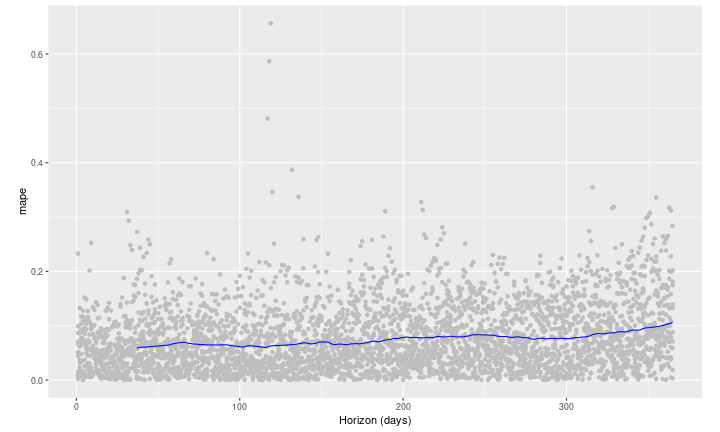

In [8]:
%%R -w 10 -h 6 -u in
plot_cross_validation_metric(df.cv, metric = 'mape')

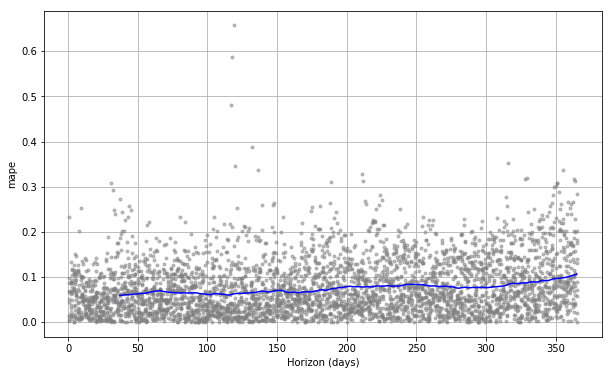

In [9]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

The size of the rolling window in the figure can be changed with the optional argument `rolling_window`, which specifies the proportion of forecasts to use in each rolling window. The default is 0.1, corresponding to 10% of rows from `df_cv` included in each window; increasing this will lead to a smoother average curve in the figure. The `initial` period should be long enough to capture all of the components of the model, in particular seasonalities and extra regressors: at least a year for yearly seasonality, at least a week for weekly seasonality, etc.


### Hyperparameter Optimisation

Auto parameter tuning can also be carried out by evaluating the parameter combinations in serial and using the in-built parallelization over cutoffs. An example implementation with multi-processing in Python is shown below, with a grid of six combinations of `changepoint_prior_scale` and `changepoint_range` parameters. The function `create_param_combinaitons` creates a dataframe of parameter combinations, which can be evaluated serially to call `single_cv_run` with the `parallel` keyword to parallelze over cutoffs. The best parameter combination is selected based on the best `rmse` score but can be switched to another performance metric depending on the use case.

As an alternative for creating parameter combinations, one could also use the `ParameterGrid` class in `sklearn.model_selection`. This would need to be installed and imported separately if required, as it is not included with Prophet.

In [2]:
from fbprophet.diagnostics import cross_validation, performance_metrics
import itertools

def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict, parallel):
    m = Prophet(**param_dict)
    m.fit(history_df)
    df_cv = cross_validation(m, initial='2600 days', period='100 days', horizon = '200 days', parallel=parallel)
    df_p = performance_metrics(df_cv, rolling_window=1)
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p


pd.set_option('display.max_colwidth', None)
param_grid = {  
                'changepoint_prior_scale': [0.05, 0.5, 5],
                'changepoint_range': [0.8, 0.9],
              }
metrics = ['horizon', 'rmse', 'mape', 'params'] 
results = []


params_df = create_param_combinations(**param_grid)
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(df,  metrics, param_dict, parallel="processes")
    results.append(cv_df)
results_df = pd.concat(results).reset_index(drop=True)
best_param = results_df.loc[results_df['rmse'] == min(results_df['rmse']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
results_df


 The best param combination is {'changepoint_prior_scale': 0.05, 'changepoint_range': 0.8}


,horizon,rmse,mape,params
0,200 days,0.450030,0.034958,"{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.8}"
1,200 days,0.453755,0.035471,"{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.9}"
2,200 days,0.456887,0.035469,"{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8}"
3,200 days,0.490453,0.039134,"{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.9}"
4,200 days,0.463969,0.036428,"{'changepoint_prior_scale': 5.0, 'changepoint_range': 0.8}"
5,200 days,0.512077,0.040488,"{'changepoint_prior_scale': 5.0, 'changepoint_range': 0.9}"


Alternatively, in some cases one could benefit from parallelizing over parameter values instead, when the number of parameter combinations are large and the user has access to a large number of cores or a cluster. In the example below,  parameter combinations are evaluated in parallel using `dask.distributed.Client`. The helper function `parallelize_param_combinations` parallelizes the calls to `single_cv_run` for each parameter combination. The cutoffs in `cross_validation` are then evaluated serially. To switch to other parallel modes in this example, import the `concurrent.futures` module and set `pool=concurrent.futures.ThreadPoolExecutor()`for execution in threads or `pool=concurrent.futures.ProcessPoolExecutor()` for multi-processing.

In [3]:
from dask.distributed import Client
import functools
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor


def parallelize_param_combinations(history_df, params_df, single_cv_callable, pool):
    results = []
    for param in params_df.values:
        param_dict = dict(zip(params_df.keys(), param))
        if isinstance(pool,(ThreadPoolExecutor, ProcessPoolExecutor)):
            future = pool.submit(single_cv_callable, history_df, param_dict=param_dict)
            results.append(future.result())
        elif isinstance(pool, Client):
            remote_df = pool.scatter(history_df)
            future = pool.submit(single_cv_callable, remote_df, param_dict=param_dict)
            results.append(future)
    if isinstance(pool, Client):
        results = pool.gather(results)
    results_df = pd.concat(results).reset_index(drop=True)
    
    return results_df


single_cv_callable = functools.partial(single_cv_run, metrics=metrics, parallel=None)

pool = Client()
results_df  = parallelize_param_combinations(df, params_df, single_cv_callable, pool=pool)
best_param = results_df.loc[results_df['rmse'] == min(results_df['rmse']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
results_df


 The best param combination is {'changepoint_prior_scale': 0.05, 'changepoint_range': 0.8}


,horizon,rmse,mape,params
0,200 days,0.450030,0.034958,"{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.8}"
1,200 days,0.453755,0.035471,"{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.9}"
2,200 days,0.456887,0.035469,"{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8}"
3,200 days,0.490453,0.039134,"{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.9}"
4,200 days,0.463969,0.036428,"{'changepoint_prior_scale': 5.0, 'changepoint_range': 0.8}"
5,200 days,0.512077,0.040488,"{'changepoint_prior_scale': 5.0, 'changepoint_range': 0.9}"


### Recommended Hyperparameter Ranges

In the examples above, we have used recommended initial settings for `changepoint_prior_scale:[0.05, 0.5, 5]` and 
`changepoint_range: [0.8, 0.9]`. We could alternatively also use a random search to carry out a sweep between a range of values e.g. `np.random.uniform(0.05, 5, 3)`. Other parameters like the `seasonality_prior_scale`, `holidays_prior_scale` and `seasonality_mode` could also be optimised for. For the seasonality and holiday prior scales, recommended values to start with are `[0.1,1,10]`, and it is better to set these  values on a log scale in the grid e.g. `np.random.uniform(-1, 1, 5)`.